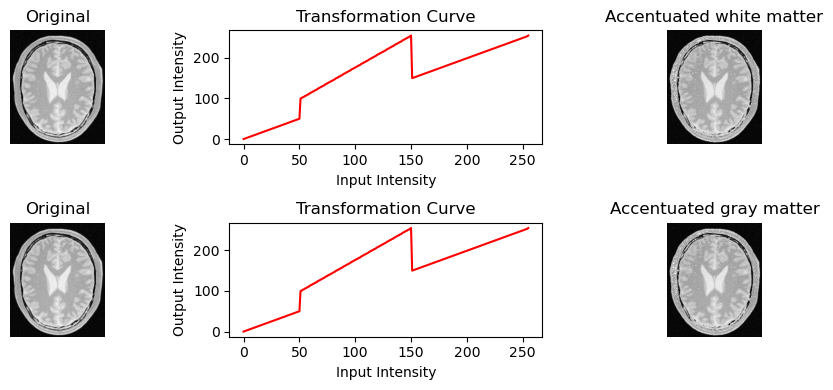

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Read teh image
img = cv.imread('a1images/brain_proton_density_slice.png', cv.IMREAD_GRAYSCALE)

# Step 2: Define the breakpoints to accenuate white matter
input_points_white = np.array([0, 50, 51, 150, 151, 255], dtype=np.uint8)
output_points_white = np.array([0, 50, 100, 255, 150, 255], dtype=np.uint8)

# Step 3: Define the breakpoints to accenuate gray matter
input_points_gray = np.array([0, 50, 51, 150, 151, 255], dtype=np.uint8)
output_points_gray = np.array([0, 50, 100, 255, 150, 255], dtype=np.uint8)

# Step 4: Create lookup table using interpolation
LUT_white = np.interp(np.arange(256), input_points_white, output_points_white).astype(np.uint8)
LUT_gray = np.interp(np.arange(256), input_points_gray, output_points_gray).astype(np.uint8)

# Step 5: Apply the transformation
white_matter = cv.LUT(img, LUT_white)
gray_matter = cv.LUT(img, LUT_gray)

# Step 6: Display results
plt.figure(figsize=(10,4))

plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Transformation Curve")
plt.plot(np.arange(256), LUT_white, color='red')
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")

plt.subplot(2,3,3)
plt.title("Accentuated white matter")
plt.imshow(white_matter, cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("Transformation Curve")
plt.plot(np.arange(256), LUT_gray, color='red')
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")

plt.subplot(2,3,6)
plt.title("Accentuated gray matter")
plt.imshow(gray_matter, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

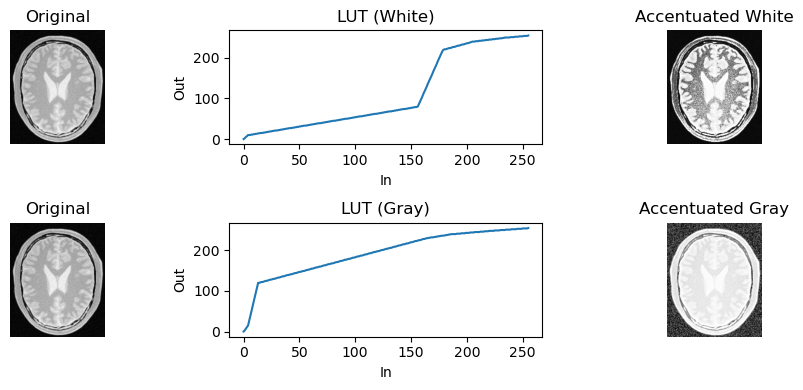

In [7]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load grayscale PD image ---
img_path = 'a1images/brain_proton_density_slice.png'  # change if needed
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Could not read image at {os.path.abspath(img_path)}")
# For LUTs, image should be 8-bit (0..255). If yours is float, rescale/convert first.

# --- Estimate simple intensity landmarks via percentiles ---
# These are generic; adjust if your dataset differs.
p1, p5, p25, p40, p60, p75, p90, p99 = np.percentile(img, [1, 5, 25, 40, 60, 75, 90, 99])

# Heuristics for PD: CSF is very bright (~p90+), WM ~ mid-high (around p60–p85), GM ~ mid (around p40–p60).
# We'll define "windows" to expand contrast around those regions.

# ---- LUT to accentuate WHITE MATTER ----
# Map: darks compressed, WM window expanded, highlights compressed (to avoid CSF dominating)
wm_lo1  = max(0,        p5)          # start of dark compression
wm_lo2  = max(wm_lo1+1, p40)         # begin ramp up to WM
wm_pk   = max(wm_lo2+1, p70 := (p60 + p75) / 2)  # WM "peak-ish" mid
wm_hi2  = max(wm_pk+1,  p90)         # after WM, start compressing
wm_hi1  = min(255,      p99)         # end

# Input breakpoints (monotone increasing)
in_wm = np.array([0, wm_lo1, wm_lo2, wm_pk, wm_hi2, wm_hi1, 255], dtype=np.float32)
# Output mapping: expand around WM (boost contrast), compress extremes
out_wm = np.array([
    0,                    # deep darks -> keep dark
    10,                   # slightly raise shadows
    80,                   # ramp toward mid
    220,                  # WM region boosted toward bright
    240,                  # roll off
    250,                  # compress highlights (CSF)
    255                   # cap
], dtype=np.float32)

LUT_white = np.interp(np.arange(256), in_wm, out_wm).astype(np.uint8).reshape(256, 1)

# ---- LUT to accentuate GRAY MATTER ----
# Map: compress darks a bit, strongly expand mid (GM), compress brights (WM/CSF)
gm_lo1  = max(0,        p5)
gm_lo2  = max(gm_lo1+1, p25)
gm_pk   = max(gm_lo2+1, p50 := (p40 + p60) / 2)  # GM "peak-ish" mid
gm_hi2  = max(gm_pk+1,  p75)
gm_hi1  = min(255,      p95 := (p90 + p99) / 2)

in_gm = np.array([0, gm_lo1, gm_lo2, gm_pk, gm_hi2, gm_hi1, 255], dtype=np.float32)
out_gm = np.array([
    0,                    # deep darks
    15,                   # slight lift in shadows
    120,                  # ramp into mid
    230,                  # GM region strongly boosted
    240,                  # roll off
    248,                  # compress upper highlights (WM/CSF)
    255
], dtype=np.float32)

LUT_gray = np.interp(np.arange(256), in_gm, out_gm).astype(np.uint8).reshape(256, 1)

# --- Apply LUTs ---
wm_enh = cv.LUT(img, LUT_white)
gm_enh = cv.LUT(img, LUT_gray)

# --- (Optional) Light sharpening only inside each mask to keep background tame ---
# Create soft masks around the targeted windows (not mandatory but can help)
wm_mask = np.clip((img.astype(np.float32) - wm_lo2) / (wm_hi2 - wm_lo2 + 1e-6), 0, 1)
gm_mask = np.clip((img.astype(np.float32) - gm_lo2) / (gm_hi2 - gm_lo2 + 1e-6), 0, 1)

def unsharp(img8, amount=0.6, radius=3):
    blur = cv.GaussianBlur(img8, (0,0), radius)
    sharp = cv.addWeighted(img8, 1+amount, blur, -amount, 0)
    return sharp

wm_sharp = unsharp(wm_enh, amount=0.5)
gm_sharp = unsharp(gm_enh, amount=0.5)

wm_final = (wm_mask * wm_sharp + (1 - wm_mask) * wm_enh).astype(np.uint8)
gm_final = (gm_mask * gm_sharp + (1 - gm_mask) * gm_enh).astype(np.uint8)

# --- Display: 2×3 ---
fig, axes = plt.subplots(2, 3, figsize=(10, 4))

axes[0, 0].imshow(img, cmap='gray');            axes[0, 0].set_title("Original");              axes[0, 0].axis('off')
axes[0, 1].plot(np.arange(256), LUT_white.flatten()); axes[0, 1].set_title("LUT (White)");     axes[0, 1].set_xlabel("In"); axes[0, 1].set_ylabel("Out")
axes[0, 2].imshow(wm_final, cmap='gray');       axes[0, 2].set_title("Accentuated White");     axes[0, 2].axis('off')

axes[1, 0].imshow(img, cmap='gray');            axes[1, 0].set_title("Original");              axes[1, 0].axis('off')
axes[1, 1].plot(np.arange(256), LUT_gray.flatten());  axes[1, 1].set_title("LUT (Gray)");      axes[1, 1].set_xlabel("In"); axes[1, 1].set_ylabel("Out")
axes[1, 2].imshow(gm_final, cmap='gray');       axes[1, 2].set_title("Accentuated Gray");      axes[1, 2].axis('off')

plt.tight_layout(); plt.show()
